# Target Selection
This notebook will use the prioritization metric discussed in prioritization_TSM_t_HIRES_ratio.ipynb to rank targets in their (planet radius, insolation flux, stellar effective temperature)-bins, and then merge the prioritized targets with those in selected_TOIs. We'll filter out targets that fail spectroscopic vetting, are already known planets, or for some other reason have 'hires_prv' = 'no'.

In [1]:
# System
import os
import sys
import glob

# Basic analysis
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100 # See all of the columns when DFs are displayed

# Generate the DataFrame with the new ranking
from X_ranking import *

# Plotting (with fancy font/backend output)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high quality figures

%load_ext autoreload
%autoreload 2

## Load the data

In [2]:
def get_newest_csv(folder_path):
    '''
    Get the filename of csv file in folder_path that is the most recent.
    
    Taken from: https://stackoverflow.com/questions/39327032/how-to-get-the-latest-file-in-a-folder-using-python
    '''
    folder_path += '*.csv'
    list_of_files = glob.glob(folder_path) # * means all if need specific format then *.csv
    return max(list_of_files, key=os.path.getctime)

toi_path = get_newest_csv('data/toi/')
tic_path = get_newest_csv('data/exofop/')
selected_TOIs_path = get_newest_csv('data/TKS/')

# Check to make sure these are the files that you want to use
print('TOI+ list file used: \t {}'.format(toi_path))
print('TIC ExoFOP file used: \t {}'.format(tic_path))
print('selected_TOIs file used: {}'.format(selected_TOIs_path))

TOI+ list file used: 	 data/toi/toi+-2020-03-23.csv
TIC ExoFOP file used: 	 data/exofop/TIC_star_info_2020-03-23.csv
selected_TOIs file used: data/TKS/selected_TOIs.csv


In [3]:
# This call will take a few seconds to execute
X_df, __________ = get_X_ranked_df(toi_path, tic_path) # Don't really need the second dataframe that's returned
print("The X_df dataframe has {} rows.".format(len(X_df)))

selected_TOIs_df = pd.read_csv(selected_TOIs_path)
print("The selected_TOIs_df dataframe has {} rows.".format(len(selected_TOIs_df)))

The X_df dataframe has 742 rows.
The selected_TOIs_df dataframe has 231 rows.


### Combining X_df and selected_TOIs
- Take the intersection of the targets from our internal ranking dataframe (which incorporates things like known planets when it assigns priorities) and the TOIs in selected_TOIs
- Filter out targets that are shaded red in the selected_TOIs spreadsheet
- Filter out known planets that made it through (shaded blue in selected_TOIs spreadsheet)
- Filter out systems that have 'hires_prv' = 'no'

In [5]:
selected_TOIs_IDs = selected_TOIs_df['toi'].values
X_tois_df = X_df[X_df['Full TOI ID'].isin(selected_TOIs_IDs)] # Get the intersection of X_df and selected_TOIs_df
print("The intersection of X_df and the selected_TOIs_df has {} rows...".format(len(X_tois_df)))

# Filter out systems that failed vetting in some way/are no longer being observed and known planets
filter_cols = ['toi', 'vetting', 'hires_prv']

# This long line merges X_tois_df and selected_TOIs_df with helpful filtering columns from selected_TOIs,
# while preserving the indices in X_tois_df, which contain binning information
X_tois_df = X_tois_df.reset_index().merge(selected_TOIs_df[filter_cols], 
                                          how='left', left_on='Full TOI ID', right_on='toi').set_index(X_tois_df.index.names)
X_tois_df = X_tois_df[X_tois_df['vetting'].isin(['passed', 'do observe'])]
print("After filtering out targets that failed spectroscopic vetting or are known planets, {} rows remain..."\
      .format(len(X_tois_df)))
X_tois_df = X_tois_df[X_tois_df['hires_prv'] != 'no']
print("After filtering out targets whose hires_prv plan is 'no', {} rows remain.".format(len(X_tois_df)))

# Of the targets remaining, how many actually have a 1, 2, or 3 priority ranking in their bin?
sys.stdout.write("Of the remaining targets, ")
for i in range(1,4):
    sys.stdout.write('{} are Priority {}'.format(len(X_tois_df[X_tois_df['X_priority'] == i]), i))
    if i in [1,2]:
        sys.stdout.write(', ')
    else:
        sys.stdout.write('.')

The intersection of X_df and the selected_TOIs_df has 102 rows...
After filtering out targets that failed spectroscopic vetting or are known planets, 88 rows remain...
After filtering out targets whose hires_prv plan is 'no', 79 rows remain.
Of the remaining targets, 5 are Priority 1, 9 are Priority 2, 10 are Priority 3.

## Make a summary plot of the prioritized candidates

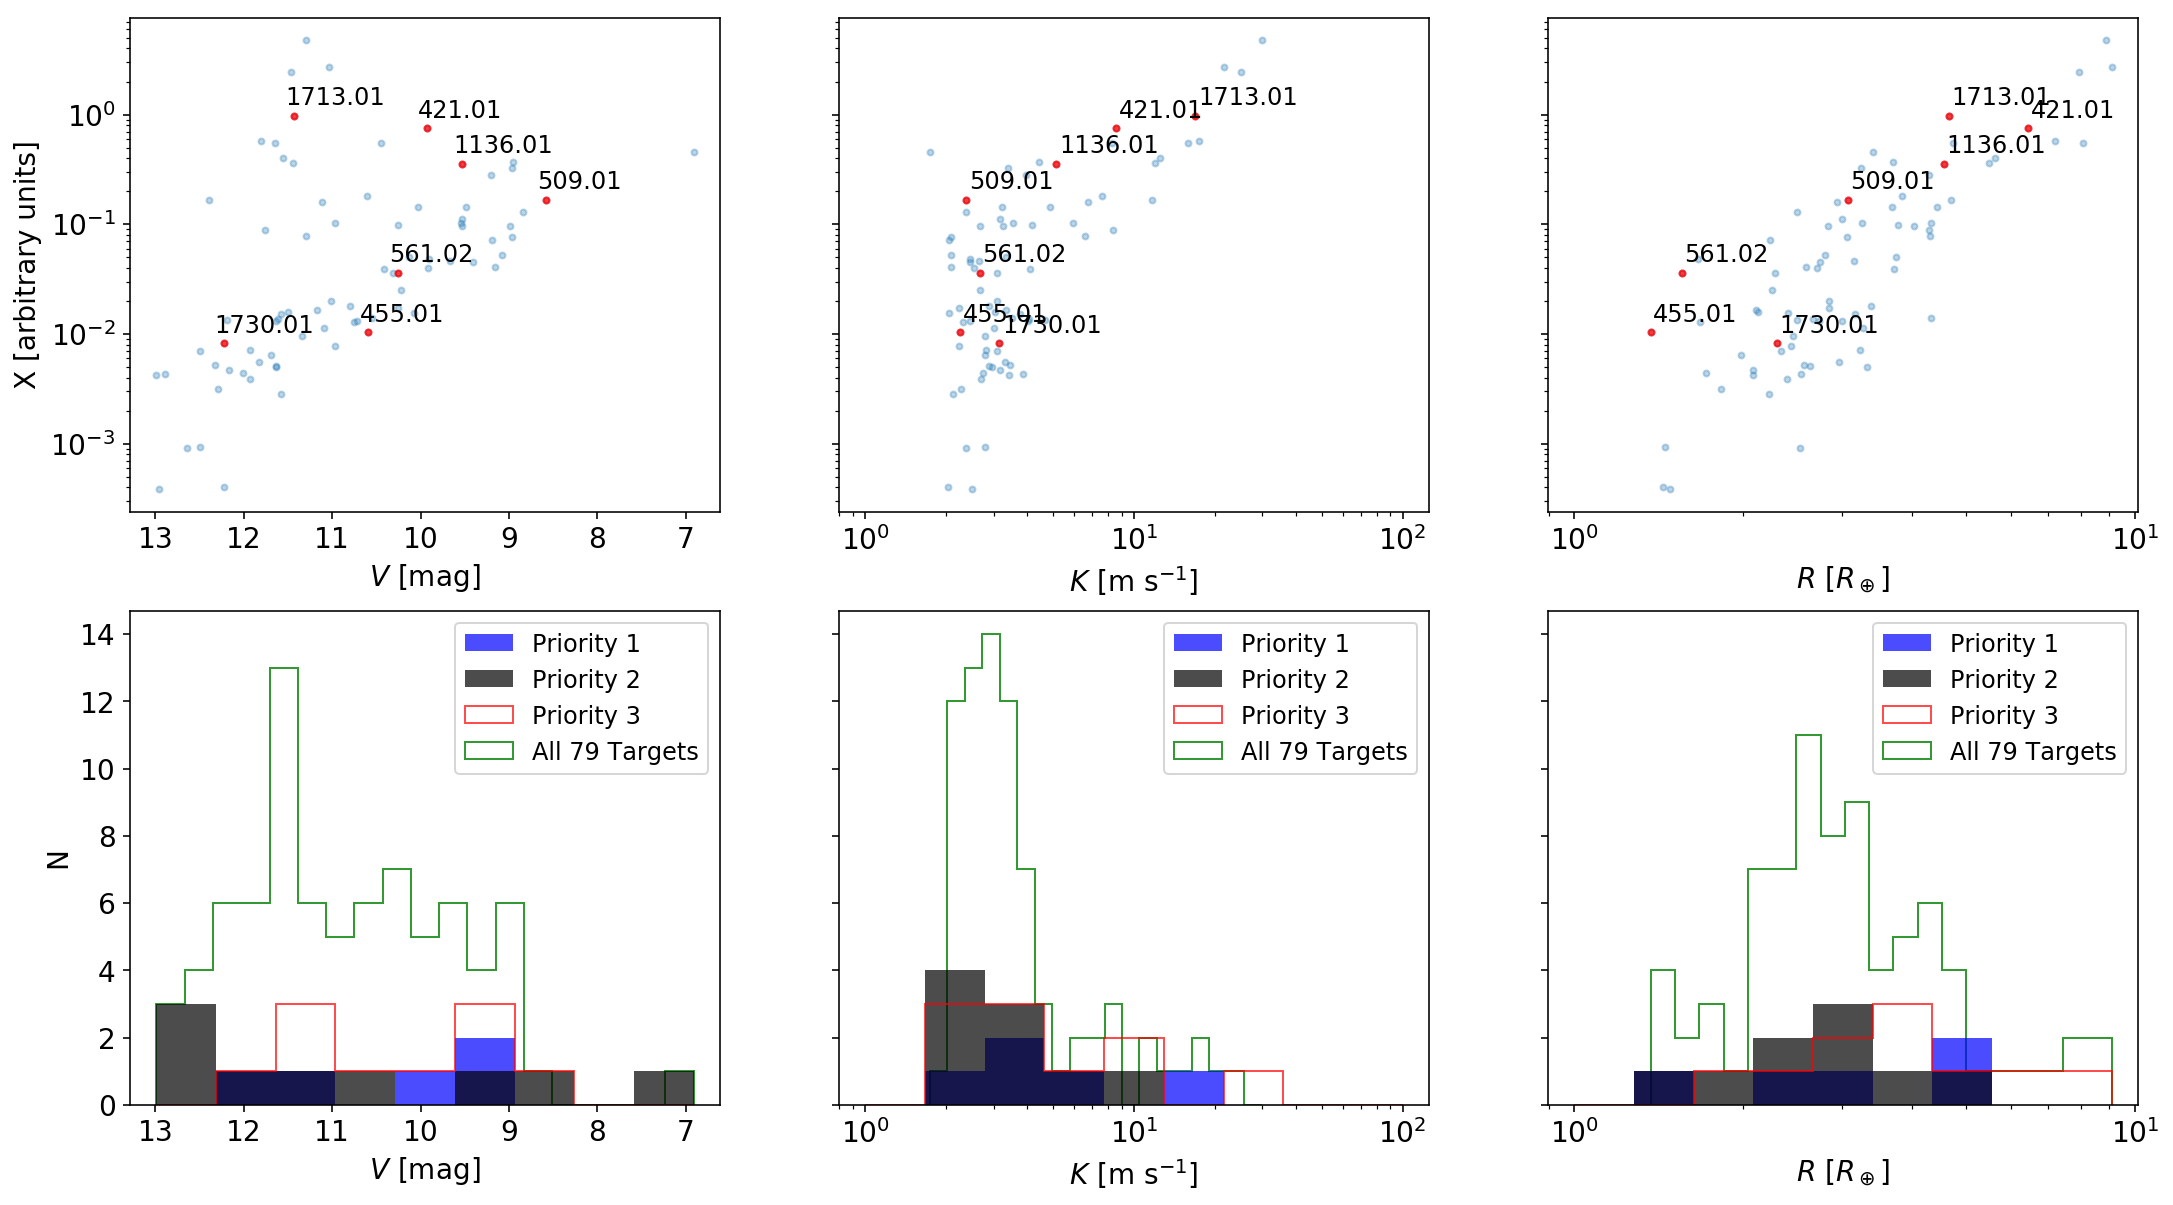

In [7]:
benchmarks = [421.01, 455.01, 509.01, 561.02, 1136.01, 1713.01, 1730.01]
fig, axes = summary_plot(X_tois_df, benchmark_targets=benchmarks)

# Plot the distribution of all of the TOIs we're considering, even those which aren't ranked in their bin
_, __, ___, ax_p_vmag, ax_p_kamp, ax_p_rad = axes.flatten()
hist_axes = [ax_p_vmag, ax_p_kamp, ax_p_rad]
hist_keys = ['V mag', 'K_amp', 'Planet Radius Value']
for ax,key in zip(hist_axes, hist_keys):
    hist_bin_num = 20
    bins = None
    if key == 'V mag':
        bins = np.linspace(X_tois_df[key].min(), X_tois_df[key].max(), hist_bin_num)
    else:
        bins = np.logspace(np.log10(X_tois_df[key].min()), np.log10(X_tois_df[key].max()), hist_bin_num)
    ax.hist(X_tois_df[key], bins=bins, zorder=0, alpha=0.8, histtype='step', color='green', label='All {} Targets'.format(len(X_tois_df)))
    ax.legend(fancybox=True, fontsize=12)
    
plt.show()

## Print out the candidates with priority rankings

In [54]:
# Print out the priority 1, 2, and 3 targets, sorted by priority and X metric
X_tois_df[X_tois_df['X_priority'].isin([1.,2.,3.])].sort_values('X', ascending=False).sort_values('X_priority')

,,,Full TOI ID,Planet Radius Value,Orbital Period Value,Effective Temperature Value,Effective Stellar Flux Value,Planet Equilibrium Temperature (K) Value,V mag,K_amp,TSM,t_HIRES,X,TSM_Vmag_priority,X_priority,toi,vetting,hires_prv
radius_bin,insol_bin,st_Teff_bin,,,,,,,,,,,,,,,,
4,5,2,1713.01,4.653690,0.557201,5097.60,3415.825831,1949.816221,11.43600,16.906352,156.077598,159.489063,0.978610,2.0,1.0,1713.01,passed,NaN
2,3,1,1730.01,2.299128,6.222236,3691.00,16.411904,513.345186,12.23000,3.149984,79.047707,9545.839154,0.008281,1.0,1.0,1730.01,passed,NaN
4,3,3,1136.01,4.559920,12.518414,5729.00,83.344567,770.617866,9.53400,5.129485,107.115012,300.526808,0.356424,2.0,1.0,1136.01,passed,yes
3,3,3,1339.01,3.247601,8.880832,5555.70,99.065848,804.638372,8.97000,3.394956,131.538519,408.095981,0.322323,2.0,1.0,1339.01,passed,yes
1,5,3,561.02,1.554210,0.446547,5391.00,4628.630447,2103.695493,10.25200,2.661764,78.276586,2162.178447,0.036203,1.0,1.0,561.02,passed,yes
3,4,2,1410.01,2.943638,1.216835,4634.60,565.541505,1243.757952,11.11100,6.752781,117.908189,741.080616,0.159103,1.0,2.0,1410.01,passed,yes
2,2,1,1468.01,2.333273,15.531925,3382.00,2.140013,308.477758,12.50000,3.097830,88.323028,12656.556228,0.006978,0.0,2.0,1468.01,passed,yes
3,2,2,1759.01,3.234794,37.696127,3960.00,2.486239,320.262031,11.93000,2.808930,64.300492,9106.447122,0.007061,3.0,2.0,1759.01,do observe,NaN
1,2,1,455.01,1.368307,5.358807,3562.00,7.379879,420.370338,10.59000,2.245208,43.269585,4148.751314,0.010430,0.0,2.0,455.01,passed,yes


With only 20 remaining ranked targets, and with there being a diversity of bins to choose from, I think it makes sense to do some sort of threshholding for the X metric (maybe only keep if X >=0.01 ?) to kick out targets that are ranked in their bin but have very low X values like 1730.01, 1468.01, 1759.01, 1695.01, 1436.01. Then we can just pop targets off the top of the stack, taking the top priority ones first, choosing the highest X value first for each priority. Seems like we'd get a somewhat good distribution over bins that way. - Joey, 03/23/20

### Get a sense of the bin distribution for the remaining ranked targets

In [9]:
X_tois_df[X_tois_df['X_priority'].isin([1.,2.,3.])]

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                    
1          2         1                455.01             1.368307   
           5         3                561.02             1.554210   
2          2         1               1468.01             2.333273   
           3         1               1730.01             2.299128   
                     1               1695.01             2.085673   
                     2               1430.01             2.229178   
           4         3               1473.01             2.493360   
           5         2               1436.01             1.717836   
3          2         2               1759.01             3.234794   
           3         2               1255.01             2.702780   
                     3               1339.01             3.247601   
                     3                469.01             3.685246   
                     3                509.01             3.073257   
           4         2               1410.01             2.943638   
                     3                554.01             3.411592   
                     3               1736.01             3.702256   
           5         3               1681.01             3.261850   
4          3         2               1728.01             4.699432   
                     3               1136.01             4.559920   
                     3               1471.01             4.282738   
           4         2                465.01             5.635860   
                     3               1288.01             4.729070   
           5         2               1713.01             4.653690   
5          3         3               1173.01             9.077533   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
1          2         1                        5.358807   
           5         3                        0.446547   
2          2         1                       15.531925   
           3         1                        6.222236   
                     1                        3.131463   
                     2                        7.434007   
           4         3                        5.255294   
           5         2                        0.867492   
3          2         2                       37.696127   
           3         2                       10.288882   
                     3                        8.880832   
                     3                       13.632935   
                     3                       18.119809   
           4         2                        1.216835   
                     3                        7.048602   
                     3                        7.074152   
           5         3                        1.537559   
4          3         2                        3.491567   
                     3                       12.518414   
                     3                       20.772024   
           4         2                        3.836317   
                     3                        2.700062   
           5         2                        0.557201   
5          3         3                        7.064560   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
1          2         1                                3562.00   
           5         3                                5391.00   
2          2         1                                3382.00   
           3         1                                3691.00   
                     1                                3575.00   
                     2                                5064.00   
           4         3                                5958.00   
           5         2                                5011.22   
3          2         2                                3960.00   
           3  